### 3F4 Lab on Convolutional Coding and Decoding

1. Encoder:
  * Convert from octal notation
  * Encoding a binary data stream
2.  Graphs:
  * How to store graphs as data structures in Python
  * Build the state diagram graph of a convolutional code
  * Build a trellis graph for a convulutional code
3. Error performance:
  * Compute the distance spectrum and transfer function
4. Decoders:
  * Implement a Viterbi decoder
  * Implement a BCJR decoder
  * Simulate and investigate coding system performance
  
Sections 1,2 and 4 were mostly pre-written for the lab and just required writing a small amount of code in order to make work. Section 3 was entirely written by me.



## 1. Encoder

In order to convert between octal notation and binary, we first need a function to convert from a number in one base to a number in another base. Here, we consider "number" to be a list of numbers where the last number in the list is the least significant number. This should do the trick:


In [1]:
import math
import numpy as np

def base2number(x,b):
    # "numbers" are stored as lists, MSB first
    # compute the number x in base b
    number = 0
    q = 1
    
    for k in reversed(x):
        number += k*q
        q *= b
        
    return(number)


def number2base(x,b,length=None):
    y = []
    
    if not length:
        length = int((math.log(x, b))) + 1
    
    for i in range(length - 1, -1, -1):
        counter = 0
        
        while x - b**i >= 0:
                counter += 1
                x -= b**i
        
        y.append(counter)
    
    return y # reverse output vector to MSB -> LSB

def base2base(x,b1,b2):
    number = base2number(x,b1)
    return(number2base(number, b2))

Now let's try this out to convert a convolutional code described in octal notation to binary "polynomial" vectors. For example, take the $(15,17)_8$ convolutional code:

In [2]:
p1 = base2base([1,5],8,2)
p2 = base2base([1,7],8,2)
print(p1)
print(p2)
print(number2base(5,2))
print(number2base(5,2,5))

[1, 1, 0, 1]
[1, 1, 1, 1]
[1, 0, 1]
[0, 0, 1, 0, 1]


In [3]:
print(base2number([1, 2, 3, 4, 5, 6], 54))

476655468


Now we need an encoder that takes a convolutional code description in octal and generates a stream of output data for a given stream of output data. This should do the trick:

In [4]:
def conv_encode_symbol(input_symbol, binary_polynomials, state=None):
    if state==None:
        state = [0]*(max([len(p) for p in binary_polynomials])-1)
        
    #print(state)
    
    state.insert(0,input_symbol)
    output = []
    
    for k in range(len(binary_polynomials)):
        output.append(int(sum(x*y for x,y in zip(state,binary_polynomials[k]))%2))
        
    state.pop()
    
    #print(input_symbol)
    #print(output)
    
    return output, state

def conv_encode_list(input_list, octal_polynomials, terminated = True):
    binary_polynomials = []
      
    for p in octal_polynomials:
        binary_polynomials.append(base2base(p,8,2))
        
    output, state = conv_encode_symbol(input_list[0],binary_polynomials)
    
    for input_symbol in input_list[1:]:
        new_output,state = conv_encode_symbol(input_symbol,binary_polynomials,state)
        output.extend(new_output)
      
    if (terminated == True):
        for n in range(len(state)):
            new_output,state = conv_encode_symbol(0,binary_polynomials,state)
            output.extend(new_output)
    
    return(output)

Let's test this for a n input symbol and for a short input list:

In [5]:
out = conv_encode_list([1, 1, 1, 1, 1, 1],[[5, 5], [7, 7]])
print(out)

[1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1]


## 2. Graphs

We now explore data structures that can store graphs in Python and use this to store a convolutional code's state diagram and trellis. 

A basic graph in python can be stored as a dictionary of nodes where each node stores a list of nodes it is connected to. For a directed graph (the only sort of graph we ware interested in in our context) we can separate this into a list of forward and backward nodes. 

Here is an example of a class that would implement such a graph, and an example of a small graph:

In [6]:
class graph_node:
    def __init__(self, name="", forward_nodes=[], backward_nodes=[]):
        self.name = name
        self.forward_nodes = forward_nodes
        self.backward_nodes = backward_nodes
    def __str__(self):
        return f"Name: {self.name}, Forward nodes: {self.forward_nodes}, Backward nodes: {self.backward_nodes}"

    
n1=graph_node(0,[1,2],[3])
n2=graph_node(1,3,0)
n3=graph_node(2,3,0)
n4=graph_node(3,0,[1,2])

print(n1)
print(n2)
print(n3)
print(n4)

Name: 0, Forward nodes: [1, 2], Backward nodes: [3]
Name: 1, Forward nodes: 3, Backward nodes: 0
Name: 2, Forward nodes: 3, Backward nodes: 0
Name: 3, Forward nodes: 0, Backward nodes: [1, 2]


However, the representation of a graph at this level is rather clonky. While establishing a data structure to store and work with graphs is simple in Python, drawing a graph is a different matter and requires some advanced programming skills. Hence, if we want to visualise our graphs we are better off importing a library that does it for us. There are several graphing libraries available in Python and we explored two in particular:
*  igraph 
*  NetworkX

I decided to use the first of the two (mainly because I liked that its name is in lower case). 

Here is the graph above stored and drawn using igraph:


In [7]:
!pip install igraph
import igraph as ig
import matplotlib.pyplot as plt

<AxesSubplot:>

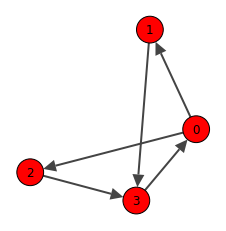

In [8]:
dummy_graph = ig.Graph(edges=[(0,1),(0,2),(1,3),(2,3),(3,0)],directed=True)
ig.plot(dummy_graph,vertex_label=range(dummy_graph.vcount()),target=plt.axes())

We can now build a function that draws the state diagram of a convolutional code as an igraph. Let us start with the $(5,7)_8$ code that we know from the lectures. 

In [9]:
def conv_state_diagram(octal_polynomials):
    binary_polynomials = []
    for p in octal_polynomials:
        binary_polynomials.append(base2base(p,8,2))
    
    output, state = conv_encode_symbol(0, binary_polynomials)
    L = len(state)
    n_vertices = 2**L
    g = ig.Graph(n_vertices, directed=True)
      
    for in_vertex in range(n_vertices):
        state=number2base(in_vertex,2,L)
        g.vs[in_vertex]["name"] = ''.join(str(n) for n in state)
        for input_symbol in [0,1]:
            state=number2base(in_vertex,2,L)    
            output,state = conv_encode_symbol(input_symbol,binary_polynomials,state)
            out_vertex = base2number(state,2)
            new_edge = g.add_edge(in_vertex,out_vertex)
            
            if in_vertex == out_vertex:  # if it's a self-loop
                new_edge["name"] = f"{str(input_symbol)}/{''.join(str(n) for n in output)}"
                new_edge["label_size"] = 0.1

            else:
                new_edge["name"] = f"{str(input_symbol)}/{''.join(str(n) for n in output)}"
                new_edge["label_angle"] = 45
                new_edge["label_size"] = 20
            
    return(g)

<AxesSubplot:>

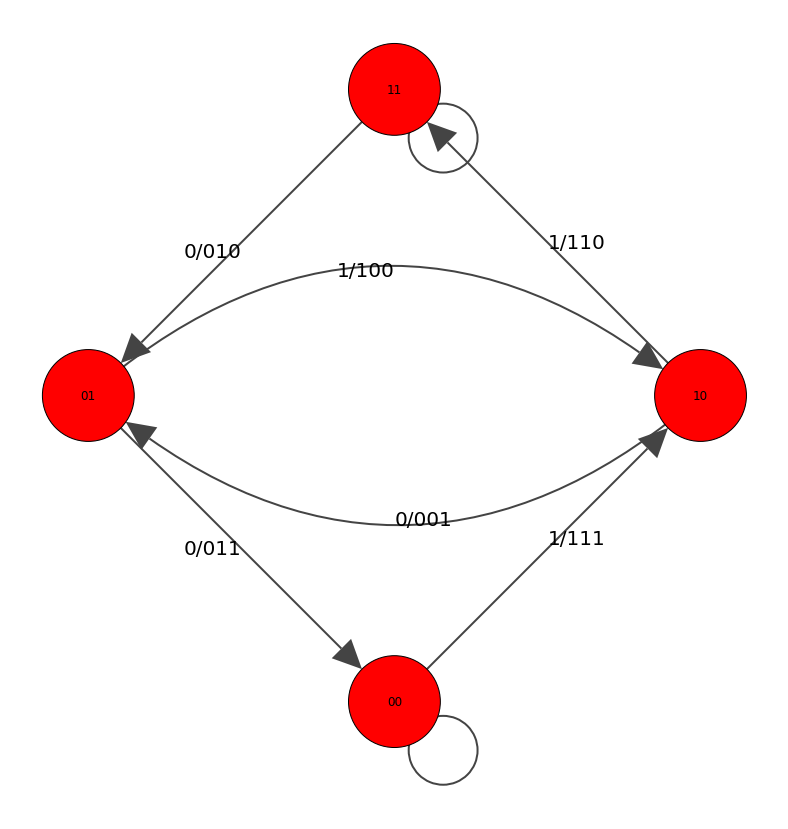

In [10]:
sd = conv_state_diagram([[4], [5], [7]])
layout = [(0,0),(-1,1),(1,1),(0,2)]
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
ig.plot(sd,vertex_label=sd.vs["name"], edge_label=sd.es["name"],target=plt.axes(), 
    vertex_size=0.3, edge_label_size=sd.es["label_size"],
    layout=layout, edge_label_angle=0) 

Now to build a trellis from the state diagram. This is a bit harder than just copying the state diagram at every turn because it's essential to include the build-up for the root for the susequent decoding algorithms to work. Termination is not important and would be difficult to programme so we left it out. In fact, once we have a Viterbi algorithm up we will discover a simple way to remove the nodes that are never attained for a terminated trellis so we will come back to this.  

In [11]:
def sd2trellis(sd, n_stages):
    td = ig.Graph(directed=True)
    root = td.add_vertex(sd.vs[0]['name'])
    root['stage'] = 0
  
    for stage in range(n_stages):
        stage_vertices = td.vs.select(stage=stage)
        #print(list(stage_vertices))
    
        for vertex in list(stage_vertices):
            sd_vertex = sd.vs.select(name=vertex['name'])
            sd_edges = sd.es.select(_source = sd_vertex[0])
            sd_targets = [edge.target for edge in sd_edges]
            for edge, target in zip(sd_edges,sd_targets):
                target_name = sd.vs[target]['name']

                if not list(td.vs.select(name=target_name, stage=stage+1)):
                    new_vertex = td.add_vertex(target_name)
                    new_vertex['stage'] = stage+1
                    new_edge = td.add_edge(vertex, new_vertex)
                else:
                    existing_vertex = td.vs.select(name=target_name,stage=stage+1)
                    new_edge = td.add_edge(vertex, existing_vertex[0])

                new_edge['name'] = edge['name']
                new_edge['stage'] = stage
 
    return(td)

Let's try this function out and draw the resulting trellis. 

<AxesSubplot:>

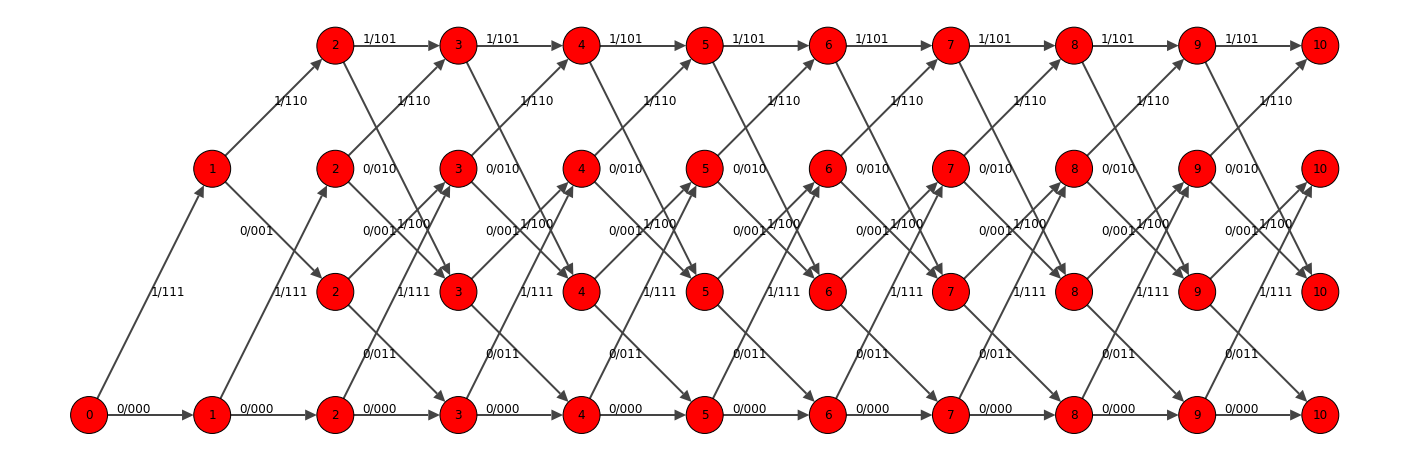

In [12]:
#print(sd)

td = sd2trellis(sd, 10)

layout = []
for vertex in td.vs.select():
    ypos = base2number([int(a) for a in vertex['name']],2)
    xpos = vertex['stage']
    layout.append((xpos,ypos))
f = plt.figure()
f.set_figwidth(25)
f.set_figheight(15)
ig.plot(td,vertex_label=td.vs["stage"], edge_label=td.es['name'], target=plt.axes(), layout=layout,vertex_size=0.3)

## 3. Symbolic computation of the graph transfer function and distance spectrum

In this section, we will add a calculation of the graph transfer function to determine the distance profile of a convolutional code. 

First we convert the state diagram to a signal flow graph to visualise detours from the all-zero state

In [13]:
def sd_to_sf(sd):
    '''Function that converts a state diagram to a signal flow diagram'''
    n_vertices = sd.vcount() + 1
    g = ig.Graph(n_vertices, directed=True)
    seen_edge_names = set()
    vertex_dict = {}
    current_ind = 1
    
    
    for e in sd.es.select():
        edge_name = e['name']
        name_v_in, name_v_out = sd.vs.select()[e.source]['name'], sd.vs.select()[e.target]['name']
        
        #The zero-state self loop is not included in the signal flow diagram
        if set(name_v_in) == set(name_v_out) == set('0'):
            continue
        
        #Creating vertex for in vertex of current edge
        if set(name_v_in) == set('0'):
            g.vs[0]['name'] = 'start'
            in_vertex = 0
            g.vs[0]['ID'] = in_vertex
        elif name_v_in not in vertex_dict:
            vertex_dict[name_v_in] = current_ind
            g.vs[current_ind]['name'] = name_v_in
            in_vertex = current_ind
            g.vs[in_vertex]['ID'] = in_vertex
            current_ind += 1    
        else:
            in_vertex = vertex_dict.get(name_v_in)
         
        #Creating vertex for end vertex of current edge
        if set(name_v_out) == set('0'):
            g.vs[-1]['name'] = 'end'
            out_vertex = n_vertices - 1
            g.vs[-1]['ID'] = out_vertex
        elif name_v_out not in vertex_dict:
            vertex_dict[name_v_out] = current_ind
            g.vs[current_ind]['name'] = name_v_out
            out_vertex = current_ind
            g.vs[out_vertex]['ID'] = out_vertex
            current_ind += 1    
        else:
            out_vertex = vertex_dict.get(name_v_out)
        
        #Create edge
        new_edge = g.add_edge(in_vertex, out_vertex)
        
        inp, outp = edge_name.split('/')
        D_exp = outp.count('1')
        if D_exp == 1 or D_exp == 0:
            D_exp = ''
        else:
            D_exp = f'^{D_exp}'
        new_edge['JND'] = 'J' + 'N'*int(inp) + 'D'*int('1' in outp) + f'{D_exp}'
             
        new_edge['name'] = edge_name
        
        if in_vertex == out_vertex:  # if it's a self-loop
                new_edge["label_size"] = 0.1 
        else:
            new_edge["label_size"] = 20
                
    
    return g
    
    

The code below is used to plot the signal flow diagram. The edge label can be changed from 'name' to 'JND' to change the edge labels from input and output bits to JND notation. The positions of the nodes must be added manually so this may be quite fiddly when using convolutional encoders with more than two delay operators. The distance spectrum can still be found without visualising the signal flow diagram.

<AxesSubplot:>

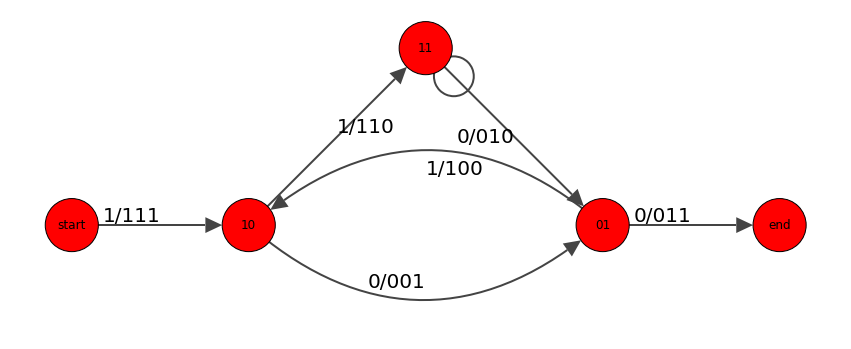

In [14]:
layout = [(0,0),(1,0),(3,0),(2,1), (4,0)]
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
sf = sd_to_sf(sd)
ig.plot(sf,vertex_label=sf.vs["name"], edge_label=sf.es["name"],target=plt.axes(), 
    vertex_size=0.3, edge_label_size=sf.es["label_size"],
    layout=layout, edge_label_angle=0) 

In order to use Mason's Gain formula, the forward paths and loops in the signal flow graph must be found. Following this, all the combinations of non-intersecting loops must be found in order to calculate the transfer function

In [15]:
#Create representation of Graph using dictionary that can be used to calculate 
#transfer function using Mason's Gain formula
from collections import defaultdict

graph = defaultdict(list)

#build new graph from list of edges
for e in sf.es.select():
    next_node = sf.vs.select()[e.target]['name']
    inp, outp = e['name'].split('/')
    graph[sf.vs.select()[e.source]['name']].append([next_node, inp, outp])
    

def find_loops_and_detours(graph):
    """Function that finds all possible cycles within and forward paths through the signal
    flow graph"""
    G = []
    L = []

    def dfs(node, seen, path, path_names_only):
        nonlocal G
        nonlocal L
        path = path.copy()  #copies must be created as sets and lists are mutable
        path_names_only = path_names_only.copy()  
        seen = seen.copy()

        if node == 'start':
            node = ['start'] #this allows the start node to be indexed like the other nodes
            
        path.append(node)
        path_names_only.append(node[0])

        if node[0] == 'end':
            G.append(path)
            return

        if node[0] in seen:
            loop = path[path_names_only.index(node[0]):]
            L.append(loop)
            return

        seen.add(node[0])
        for next_node in graph[node[0]]:
            dfs(next_node, seen, path, path_names_only)
        
    dfs('start', set(), [], [])
    return G, L

G, L = find_loops_and_detours(graph)

The cell below prints the forward paths and loops in the signal flow graph in terms of the state transitions so
that they can be visualised

In [16]:
L_names_only = []

for loop in L:
    arr = []
    arr.extend([i[0] for i in loop])
    L_names_only.append(arr)
    
G_names_only = []

for path in G:
    arr = []
    arr.extend([i[0] for i in path])
    G_names_only.append(arr)
    
print('\n Forward Paths:')
for i in range(len(G)):
    print(f'G_{i+1}: {G_names_only[i]}')

print('\n Loops:')
for i in range(len(L)):
    print(f'L_{i+1}: {L_names_only[i]}')


 Forward Paths:
G_1: ['start', '10', '01', 'end']
G_2: ['start', '10', '11', '01', 'end']

 Loops:
L_1: ['10', '01', '10']
L_2: ['10', '11', '01', '10']
L_3: ['11', '11']


An intersection matrix to determine with any pair of paths/loops intersects is obtained using the function below

In [17]:
def path_intersection(n, paths):
    m = len(paths)
    intersection_matrix = [[0 for j in range(m)] for i in range(m)]

    # create a dictionary containing a set of paths that contain each node
    node_dict = defaultdict(set)
    for i, path in enumerate(paths):
        for node in path:
            node_dict[node[0]].add(i)
    
    #Find pairs of paths with overlapping nodes
    for i in range(m):
        for j in range(i+1, m):
            for node in node_dict.keys():
                if i in node_dict[node] and j in node_dict[node]:
                    intersection_matrix[i][j] = 1
                    intersection_matrix[j][i] = 1
                    break
    
    return intersection_matrix

In [18]:
paths = G + L
intersection_matrix_all = path_intersection(5, paths) #intersection matrix for the forward paths and loops
intersection_matrix_L = path_intersection(3, L) #intersection matrix for the loops only
print(intersection_matrix_all)
print(intersection_matrix_L)

[[0, 1, 1, 1, 0], [1, 0, 1, 1, 1], [1, 1, 0, 1, 0], [1, 1, 1, 0, 1], [0, 1, 0, 1, 0]]
[[0, 1, 0], [1, 0, 1], [0, 1, 0]]


Finding all the possible combinations of non-intersecting loops can be treated as a separate graph problem where
the loops are treated as nodes and there are edges between said nodes when two loops intersect.

In [19]:
from itertools import combinations

def find_unconnected_loops(intersection_mat):
    '''By considering all possible combinations of loops and using the intersection matrix,
    this function returns all possible combinations of non-intersecting loops'''
    n = len(intersection_mat)
    nodes = set(range(1, n+1))
    groups = []
    for i in range(1, n+1):
        for combination in combinations(nodes, i):
            connected = False
            for pair in combinations(combination, 2):
                if intersection_mat[pair[0]-1][pair[1]-1] == 1:
                    connected = True
                    break
            if not connected:
                groups.append(set(combination))
    return groups

In [20]:
non_intersecting_loops = find_unconnected_loops(intersection_matrix_L)
print(f'Non intersecting loops: {non_intersecting_loops}')

Non intersecting loops: [{1}, {2}, {3}, {1, 3}]


In [21]:
def find_JND_exponents(arr):
    arr_JND = []
    
    for g in arr:
        J_exp = len(g) - 1
        N_exp = sum(int(node[1] == '1') for node in g[1:])
        D_exp = sum(node[2].count('1') for node in g[1:])
        
        arr_JND.append([J_exp, N_exp, D_exp])
        
    return arr_JND
        
G_JND = find_JND_exponents(G)
L_JND = find_JND_exponents(L)

print(G_JND)
print(L_JND)

[[3, 1, 6], [4, 2, 8]]
[[2, 1, 2], [3, 2, 4], [1, 1, 2]]


In [22]:
from sympy import symbols
from sympy import *


J, N, D = symbols('J N D')
terms = []

#Compute determinant
for combi in non_intersecting_loops:
    terms.append((-1)**(len(combi)) * J**sum([L_JND[loop - 1][0] for loop in combi]) 
                       * N**sum([L_JND[loop - 1][1] for loop in combi]) 
                       * D**sum([L_JND[loop - 1][2] for loop in combi]))
    
det = 1 + sum(terms)
print(f'Determinant: {det}')  

Determinant: -D**2*J**2*N - D**2*J*N + 1


In [23]:
from sympy import simplify
from sympy import factor
terms = []

#Compute numerator to be used in Mason's Gain Formula
for i in range(len(G)):
    
    #Remove any loops that intersect with path from the list of non-intersecting groups
    ni_loops_new = non_intersecting_loops.copy()
    i_loops = []
    for j in range(len(L)):
        if intersection_matrix_all[i][len(G) + j] == 1:
            for k in range(len(ni_loops_new)):
                if j+1 in ni_loops_new[k]:
                    i_loops.append(ni_loops_new[k])              
    
    for int_loop in (i_loops):
        try:
            ni_loops_new.remove(int_loop)
        except ValueError:
            pass
    
    termsL = []
    
    if ni_loops_new:
        for combi in ni_loops_new:
            termsL.append((-1)**(len(combi)) * J**sum([L_JND[loop - 1][0] for loop in combi]) 
                               * N**sum([L_JND[loop - 1][1] for loop in combi]) 
                               * D**sum([L_JND[loop - 1][2] for loop in combi]))      
        det_i = 1 + sum(termsL)
            
    else:
        det_i = 1
            
    G_i = J**G_JND[i][0] * N**G_JND[i][1] * D**G_JND[i][2]
    terms.append(G_i*det_i)
      
num = sum(terms)
T = num/factor(det)
T_simp = simplify(T)
print(T)
print(T_simp)
print(latex(T_simp)

(D**8*J**4*N**2 + D**6*J**3*N*(-D**2*J*N + 1))/(-D**2*J**2*N - D**2*J*N + 1)
-D**6*J**3*N/(D**2*J**2*N + D**2*J*N - 1)
- \frac{D^{6} J^{3} N}{D^{2} J^{2} N + D^{2} J N - 1}


The transfer function can be converted to a power series using the sum of a geometric sequence formula; from 
this form the distance profile of the code can be identified

In [31]:
from sympy import expand

a = -T_simp.as_numer_denom()[0] #multiply both numerator and denominator by -1 for simplification
one_minus_r = -T_simp.as_numer_denom()[1]
r = 1 - one_minus_r

print(f'a: {a} \n1-r: {1-r}')

a: D**6*J**3*N 
1-r: -D**2*J**2*N - D**2*J*N + 1


['D**120*J**60*N**58', '56*D**118*J**60*N**57', '1485*D**116*J**60*N**56', '24804*D**114*J**60*N**55', '292825*D**112*J**60*N**54', '2598960*D**110*J**60*N**53', '18009460*D**108*J**60*N**52', '99884400*D**106*J**60*N**51', '450978066*D**104*J**60*N**50', '1677106640*D**102*J**60*N**49', '5178066751*D**100*J**60*N**48', '13340783196*D**98*J**60*N**47', '28760021745*D**96*J**60*N**46', '51915526432*D**94*J**60*N**45', '78378960360*D**92*J**60*N**44', '98672427616*D**90*J**60*N**43', '103077446706*D**88*J**60*N**42', '88732378800*D**86*J**60*N**41', '62359143990*D**84*J**60*N**40', '35345263800*D**82*J**60*N**39', '15905368710*D**80*J**60*N**38', '5567902560*D**78*J**60*N**37', '1476337800*D**76*J**60*N**36', '286097760*D**74*J**60*N**35', '38567100*D**72*J**60*N**34', '3365856*D**70*J**60*N**33', '169911*D**68*J**60*N**32', '4060*D**66*J**60*N**31', '29*D**64*J**60*N**30']


Text(0, 0.5, 'Counts')

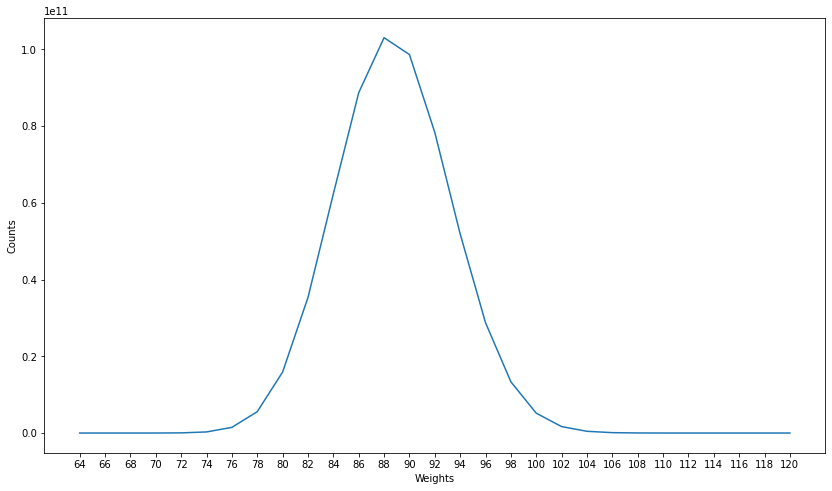

In [50]:
n = 60 #for input sequences of length n
terms = []
for j in range(n):
    terms.append(expand(simplify(a*r**j))) #expand sum and collect together like terms

string = str(sum(terms))
terms_individual = string.split(' + ') #split the sum into its terms
#print(terms_individual)

#function to truncate geometric sequence for a certain input length 
def truncate_above_n_inputs(n_inp, terms): 
    final = []
    for i in range(len(terms)):
        if int(terms[i].split('**')[2].split('*')[0]) == n: # only add sequences with J exponent = n
            final.append(terms[i])
        
    return final

final_terms = truncate_above_n_inputs(50, terms_individual)
weights_dict = defaultdict(int)
print(final_terms)

for term in final_terms:
    weight = term.split('**')[1].split('*')[0]
    if term[0] == 'D':
        count = 1
    else:
        count = int(term.split('*')[0])
    weights_dict[weight] += count

weights = list(weights_dict.keys())
values = list(weights_dict.values())
weights.reverse()
values.reverse()

#print(weights_dict)    
fig, ax = plt.subplots(1, figsize = (14, 8))
ax.plot(weights, values)

ax.set_xlabel('Weights')
ax.set_ylabel('Counts')

## 4. Decoders

To look into trellis-based decoders, we first need to transmit some data over a noisy channel. We generate random data and encode it with a convolutional encoder, say $(15,17)_8$. 

In [ ]:
import random as rand

data_length = 12
# conv code polynomials
p1 = [5] 
p2 = [7]
data = rand.getrandbits(data_length)
data = number2base(data,2,data_length)
codeword = conv_encode_list(data,[p1,p2])
# we rebuild the state diagram and trellis here to match the lengths (in case you fiddled with parameters in the first part of the lab)
sd = conv_state_diagram([p1,p2])
n_delays = len(sd.vs[0]['name'])
td = sd2trellis(sd, data_length+n_delays)

We want to test decoders over a range of channel, say binary erasure channels (BEC), binary symmetric channels (BSC), and a Binary-input Additive White Gaussian Noise (BiAWGN) channel.

In [ ]:
def Bernoulli(n,p):
    return([int(rand.random()<p) for n in range( n )])

def bec(x,p):
    n = len(x)
    e = Bernoulli(n,p)
    return([a if b == 0 else '?' for a,b in zip(x,e)])

def bsc(x,p):
    n = len(x)
    return([int((a+b)%2) for a,b in zip(x,Bernoulli(n,p))])

def awgn(x,sigma):
    return([a+rand.gauss(0,sigma) for a in x])
  

print(bec(codeword,.3))
print(bsc(codeword,.3))
print(awgn([1-x*2 for x in codeword],.5))  

We now build a Viterbi decoder. The Viterbi decoder best works in the logarithmic domain with an additive metric proportional to $-\log P(y|x)$, so that it turns into an algorithm that searches for the minimum metric path in order to achieve maximum likelihood. The algorithm has 3 phases:
* first we assign a metric $\gamma$ to every edge in the trellis
* then, we run the actual algorithm that computes metrics for the vertices by adding edge metrics to the metric of their originating vertex, and selecting the path of minimum metric when paths merge
* finally, we retrace our step backward to extract the minimum metric path.

We will consider a rooted and terminated trellis, since we returned our encoder to the zero state. This means that certain edges vertices in the trellis we drew earlier will never be visited by the decoder if they are not on a path from the root to the toor, but there is no harm in computing edge metrics for those edges in phase 1. 

Note that I am capitalising Viterbi because I've met Andy Viterbi many times and although he is a fantastic engineer with much to his credit, and inventing this algorithm has certainly boosted his position in the history of telecommunications to a phenomenal dimension, I nevertheless don't feel completely comfortable in reducing his name to a lower-case object as if he were a household item like a hoover. If you haven't met Andy and prefer to think of "viterbi" as a quirky name for an algorithm rather than his surname, you are more than welcome to edit the function name below and remove the stylistic clash in python naming conventions. (Note that I also capitalised "Bernoulli" although I obviously never met him, but I do feel a special connection with him on account of our shared citizenship....)

In [ ]:
def Viterbi(y, td, channel='bsc'):
  # phase 1: compute gammas
    N = len([int(a) for a in td.es[0]['name'][2:]]) # code rate 1/N
    for edge in td.es.select():
        edge_output = [int(a) for a in edge['name'][2:]]
        y_pos = edge['stage']*N
        y_slice = y[y_pos:y_pos+N]
    
        if channel == 'bsc':
            edge['gamma'] = sum([int(a != b) for a,b in zip(edge_output, y_slice)])
        elif channel == 'bec':
            diff = [0 if (b=='?' or a == b) else 1 for a,b in zip(edge_output, y_slice)]
            if sum(diff) == 0:
                edge['gamma'] = 0
            else: 
                edge['gamma'] = 1 # 1 is infinity for the BEC!
        
        elif channel == 'awgn':
            modulated_output = [1-2*a for a in edge_output]
            edge['gamma'] = sum([(a-b)**2 for a,b in zip(modulated_output, y_slice)])

  # phase 2: compute alphas
  # This phase can be implemented in a purely "forward" way if you are confident
  # of being able to visit your vertices in an order that will only ever visit 
  # a vertex when all of its incoming edges are connected to vertices whose 
  # alpha have already been computed. The approach implemented here is a bit
  # different and was suggested to me by my 4th year project student
  # Omar Zaman: we start from the TOOR and operate a "stack" of nodes that
  # we are unable to compute. For the node at the top of the stack, we check
  # if its incoming neighbours have already been resolved. If yes, we resolve
  # the node and remove it from the stack. If not, on the other hand, then
  # we add the incoming neighbours to the stack.
    for vertex in td.vs.select():
        vertex['alpha'] = -1 # initialise all vertices to -1
    state_length = len(td.vs[0]['name'])
    root = td.vs.select(name='0'*state_length,stage=0)
    toor = td.vs.select(name='0'*state_length,stage=len(y)/N)
    root[0]['alpha'] = 0 # initialise root vertex to 0
    vstack = [toor[0].index]
    while vstack:
        cnode = vstack[-1]
        incoming = td.es.select(_target=cnode)
        if not list(incoming):
            vstack.pop()
            continue
        sources = [a.source for a in incoming]
        source_alphas = td.vs[sources]['alpha']
        if all([x == -1 for x in source_alphas]):  # all origins are uncomputed
            for a in incoming:
                vstack.append(a.source)
        else: # some origins computed, node can be resolved
            min_alpha = -1
            winner = -1
      
            for a in incoming:
                a['winner'] = 'loser' # preset all incoming to losing
                candidate_alpha = a['gamma'] + td.vs[a.target]['alpha']
                if min_alpha == -1 or candidate_alpha < min_alpha:
                    winner = a
                    min_alpha = candidate_alpha
            td.vs[cnode]['alpha'] = min_alpha
            winner['winning'] = 'winner' # record the winning incoming
            vstack.pop() # delete vertex from stack

  # phase 3: backtrack to read out the winning path and metric
    cnode = toor[0];
    decoded = []
    while (cnode['stage'] > 0):
        winner = td.es.select(_target=cnode.index, winning='winner')
        decoded.append(int(winner[0]['name'][0]))
        cnode = td.vs[winner[0].source]
    decoded.reverse()
    min_metric = toor[0]['alpha']
    return decoded, min_metric



In [ ]:
y = bsc(codeword, .1)
decoded,hamming_distance = Viterbi(y,td,'bsc')
print(f'Codeword:         {codeword}')
print(f'Transmitted word: {y}\n')
print(f'Encoded data:                        {data}')
print(f'Decoded word (with termination bits: {decoded}\n')
print(f'Hamming Distance: {hamming_distance}')

We can nicely visualise the operation of the Viterbi algorithm by labeling nodes with the $\alpha$ values and edges with their $\gamma$ values.